In [1]:
# 20160529
# creates UE_adj.csv file for sUE calcs
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## 7/23/15: remove dUE3 and all other dUE variables (not useful)... then add scaled UE2 variable
## 7/14/15:  added dUE3 to both files
## new file for econ variables only:  add lags, exp, dif xforms, then save for future use.
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

In [3]:
## history vars: 4q lags & 4q differences for UE, HPI, CRE (also, try 6q & 8q lags for UE only)
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']
hs['UE_42'] = hs['UE_4'] * hs['UE_4']

hsx = hs.copy()
hsx[hsx['Date']>'2001-01-01'].head()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI   T3m   T5y  T10y  \
100 2001-03-31   -1.1    1.4   3.5   6.3  4.2  3.9  4.95  4.80  5.05   
101 2001-06-30    2.1    5.1  -0.3   1.6  4.4  2.8  3.75  4.83  5.27   
102 2001-09-30   -1.3    0.0   9.8  10.1  4.8  1.1  3.24  4.48  4.98   
103 2001-12-31    1.1    2.3  -4.9  -4.6  5.5 -0.3  1.94  4.09  4.77   
104 2002-03-31    3.7    5.1  10.1  10.9  5.7  1.3  1.76  4.46  5.08   

       ...      Prime       DJ    HPI    CRE   VIX      UE_4       HPI_4  \
100    ...       8.62  10645.9  113.2  139.5  32.8  4.033333  101.617952   
101    ...       7.34  11407.2  115.2  138.6  34.7  3.933333  104.477712   
102    ...       6.57   9563.0  117.5  141.0  43.7  4.000000  106.935553   
103    ...       5.16  10707.7  119.8  135.6  35.3  3.900000  109.482955   
104    ...       4.75  10775.7  122.1  137.4  26.1  4.200000  113.200000   

       CRE_4    UE2      UE_42  
100  127.211  17.64  16.267778  
101  123.935  19.36  15.471111  
102  138.736  23.04  16.000000  
103  143.300  30.25  15.210000  
104  139.500  32.49  17.640000  

[5 rows x 22 columns]

In [4]:
hsx.to_csv("hist_lagexp.csv")
hsy = hsx[hsx['Date']>'2001-01-01'].copy()
hsy.set_index('Date',drop=True,inplace=True)
hsy.head()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI   T3m   T5y  T10y   BBB  \
Date                                                                     
2001-03-31   -1.1    1.4   3.5   6.3  4.2  3.9  4.95  4.80  5.05  7.88   
2001-06-30    2.1    5.1  -0.3   1.6  4.4  2.8  3.75  4.83  5.27  8.04   
2001-09-30   -1.3    0.0   9.8  10.1  4.8  1.1  3.24  4.48  4.98  7.95   
2001-12-31    1.1    2.3  -4.9  -4.6  5.5 -0.3  1.94  4.09  4.77  7.92   
2002-03-31    3.7    5.1  10.1  10.9  5.7  1.3  1.76  4.46  5.08  7.96   

              ...      Prime       DJ    HPI    CRE   VIX      UE_4  \
Date          ...                                                     
2001-03-31    ...       8.62  10645.9  113.2  139.5  32.8  4.033333   
2001-06-30    ...       7.34  11407.2  115.2  138.6  34.7  3.933333   
2001-09-30    ...       6.57   9563.0  117.5  141.0  43.7  4.000000   
2001-12-31    ...       5.16  10707.7  119.8  135.6  35.3  3.900000   
2002-03-31    ...       4.75  10775.7  122.1  137.4  26.1  4.200000   

                 HPI_4    CRE_4    UE2      UE_42  
Date                                               
2001-03-31  101.617952  127.211  17.64  16.267778  
2001-06-30  104.477712  123.935  19.36  15.471111  
2001-09-30  106.935553  138.736  23.04  16.000000  
2001-12-31  109.482955  143.300  30.25  15.210000  
2002-03-31  113.200000  139.500  32.49  17.640000  

[5 rows x 21 columns]

In [5]:
hsy.columns

Index([u'rGDPg', u'nGDPg', u'rDIg', u'nDIg', u'UE', u'CPI', u'T3m', u'T5y',
       u'T10y', u'BBB', u'Mort', u'Prime', u'DJ', u'HPI', u'CRE', u'VIX',
       u'UE_4', u'HPI_4', u'CRE_4', u'UE2', u'UE_42'],
      dtype='object')

In [6]:
ccy = cc.copy()
ccy[['UE_4','HPI_4','CRE_4']] = ccy.groupby(['CCAR','Scen'])[['UE','HPI','CRE']].shift(4)
ccy.head(7)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m  ...    \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0  ...     
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1  ...     
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1  ...     
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1  ...     
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1  ...     
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1  ...     
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1  ...     

    BBB  Mort  Prime        DJ     HPI     CRE    VIX    UE_4   HPI_4  CRE_4  
0  4.90  4.30    NaN  11676.50  137.30  177.00  48.00     NaN     NaN    NaN  
1  4.52  4.21    NaN  11936.09  137.21  172.17  35.97     NaN     NaN    NaN  
2  4.55  4.17    NaN  12090.22  137.55  173.29  35.08     NaN     NaN    NaN  
3  4.59  4.15    NaN  12242.03  137.89  175.43  31.83     NaN     NaN    NaN  
4  4.74  4.19    NaN  12401.69  138.24  177.65  31.35  177.00  137.30    9.0  
5  4.89  4.24    NaN  12562.14  138.58  178.87  29.59  172.17  137.21    9.1  
6  5.15  4.34    NaN  12725.49  138.93  182.28  28.43  173.29  137.55    9.1  

[7 rows x 22 columns]

In [7]:
for i in np.arange(len(ccy)):
  if np.isnan(ccy.ix[i]['UE_4']):
    yr = ccy.ix[i]['Date'].year - 1
    mn = ccy.ix[i]['Date'].month
    dy = ccy.ix[i]['Date'].day
    dd = str(datetime(yr,mn,dy))[0:7]
    xu = hsy[dd]['UE'].values
    ccy.loc[i,'UE_4'] = xu
    xh = hsy[dd]['HPI'].values
    ccy.loc[i,'HPI_4'] = xh
    xc = hsy[dd]['CRE'].values
    ccy.loc[i,'CRE_4'] = xc

ccy.head(6)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  ...     BBB  \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  ...    4.90   
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  ...    4.52   
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.1  2.0  0.1  ...    4.55   
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.0  1.9  0.1  ...    4.59   
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.9  2.2  0.1  ...    4.74   
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.9  2.1  0.1  ...    4.89   

   Mort  Prime        DJ     HPI     CRE    VIX    UE_4   HPI_4  CRE_4  
0  4.30    NaN  11676.50  137.30  177.00  48.00    9.50  141.30  166.9  
1  4.21    NaN  11936.09  137.21  172.17  35.97    9.60  140.00  172.7  
2  4.17    NaN  12090.22  137.55  173.29  35.08    9.00  138.10  179.6  
3  4.15    NaN  12242.03  137.89  175.43  31.83    9.10  137.30  177.0  
4  4.19    NaN  12401.69  138.24  177.65  31.35  177.00  137.30    9.0  
5  4.24    NaN  12562.14  138.58  178.87  29.59  172.17  137.21    9.1  

[6 rows x 22 columns]

In [8]:
ccy['UE2'] = ccy['UE'] * ccy['UE']
ccy['UE_42'] = ccy['UE_4'] * ccy['UE_4']
ccy.to_csv('CCARscen_lagexp.csv')
ccy.head()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m    ...     \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0    ...      
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1    ...      
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.1  2.0  0.1    ...      
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.0  1.9  0.1    ...      
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.9  2.2  0.1    ...      

   Prime        DJ     HPI     CRE    VIX   UE_4  HPI_4  CRE_4    UE2  \
0    NaN  11676.50  137.30  177.00  48.00    9.5  141.3  166.9  81.00   
1    NaN  11936.09  137.21  172.17  35.97    9.6  140.0  172.7  82.81   
2    NaN  12090.22  137.55  173.29  35.08    9.0  138.1  179.6  82.81   
3    NaN  12242.03  137.89  175.43  31.83    9.1  137.3  177.0  81.00   
4    NaN  12401.69  138.24  177.65  31.35  177.0  137.3    9.0  79.21   

      UE_42  
0     90.25  
1     92.16  
2     81.00  
3     82.81  
4  31329.00  

[5 rows x 24 columns]

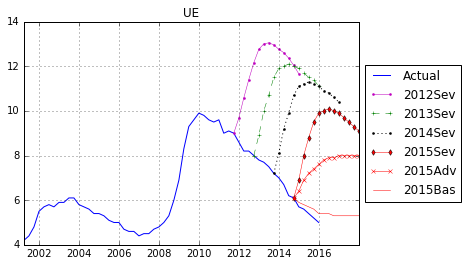

In [9]:
vv = 'UE'
hsx1 = hsx[hsx['Date']>'2001-01-01']
hsx1.set_index('Date', drop=True, inplace=True)
cc2 = ccy[['Date','CCAR','Scen',vv]]
cc2['YrSc'] = cc2.apply(lambda x: str(x['CCAR'])+x['Scen'],axis=1)
cc2p = cc2.pivot('Date','YrSc',vv)
#cc2p.head()
hsx2 = hsx1.merge(cc2p, how='outer', left_index=True, right_index=True)
#hsx2.tail()

x = list(hsx2.index)

plt.plot(x,hsx2[vv],c='b',label='Actual')
plt.plot(x,hsx2['2012Sev'],ls='-',c='m',lw=.5,marker='.',ms=4,label='2012Sev')
plt.plot(x,hsx2['2013Sev'],ls='--',c='g',lw=.5,marker='+',ms=4,label='2013Sev')
plt.plot(x,hsx2['2014Sev'],ls=':',c='k',lw=1,marker='.',ms=4,label='2014Sev')
plt.plot(x,hsx2['2015Sev'],c='r',lw=.5,marker='d',ms=4,label='2015Sev')
plt.plot(x,hsx2['2015Adv'],c='r',lw=.5,marker='x',ms=4,label='2015Adv')
plt.plot(x,hsx2['2015Bas'],c='r',lw=.5,label='2015Bas')
plt.title(vv)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.savefig(vv+'_chart.png', dpi=400, bbox_inches='tight')
plt.show()

In [10]:
hsue = pd.DataFrame(hsy.ix['2001':'2019']['UE'])
hsue.reset_index(drop=False, inplace=True)
hsue.tail()

Date   UE
55 2014-12-31  5.7
56 2015-03-31  5.6
57 2015-06-30  5.4
58 2015-09-30  5.2
59 2015-12-31  5.0

In [11]:
ccs = ccy[ccy['Scen']=='Sev'][['CCAR','Date','UE']]
ccs = ccs.pivot('Date','CCAR','UE')
ccs.reset_index(drop=False, inplace=True)
ccs.columns = ['Date','u12','u13','u14','u15','u16']
ccs.tail()

Date  u12  u13  u14  u15  u16
26 2018-03-31  NaN  NaN  NaN  NaN  9.8
27 2018-06-30  NaN  NaN  NaN  NaN  9.6
28 2018-09-30  NaN  NaN  NaN  NaN  9.4
29 2018-12-31  NaN  NaN  NaN  NaN  9.1
30 2019-03-31  NaN  NaN  NaN  NaN  8.9

In [12]:
hsue2 = hsue.merge(ccs,how='outer',on='Date')
hsue2.set_index('Date', drop=True, inplace=True)
hsue2.tail()

UE  u12  u13  u14  u15  u16
Date                                   
2018-03-31 NaN  NaN  NaN  NaN  NaN  9.8
2018-06-30 NaN  NaN  NaN  NaN  NaN  9.6
2018-09-30 NaN  NaN  NaN  NaN  NaN  9.4
2018-12-31 NaN  NaN  NaN  NaN  NaN  9.1
2019-03-31 NaN  NaN  NaN  NaN  NaN  8.9

In [13]:
hsue2['Qn'] = hsue2.index.year * 4 + hsue2.index.month /3
hsue2['Qn'] = hsue2['Qn'].astype(int)
hsue2.tail()

UE  u12  u13  u14  u15  u16    Qn
Date                                         
2018-03-31 NaN  NaN  NaN  NaN  NaN  9.8  8073
2018-06-30 NaN  NaN  NaN  NaN  NaN  9.6  8074
2018-09-30 NaN  NaN  NaN  NaN  NaN  9.4  8075
2018-12-31 NaN  NaN  NaN  NaN  NaN  9.1  8076
2019-03-31 NaN  NaN  NaN  NaN  NaN  8.9  8077

In [14]:
mx = hsue2[['UE','u12','u13','u14','u15','u16']].max()
mx = pd.DataFrame(mx)
mx.columns = ['mx']
mxdct = mx.to_dict()
mxdct['mx']

{'UE': 9.9000000000000004,
 'u12': 13.050000000000001,
 'u13': 12.1,
 'u14': 11.300000000000001,
 'u15': 10.1,
 'u16': 10.0}

In [15]:
mxd = hsue2[hsue2['UE']==mxdct['mx']['UE']]['Qn']
mxd12 = hsue2[hsue2['u12']==mxdct['mx']['u12']]['Qn']
mxd13 = hsue2[hsue2['u13']==mxdct['mx']['u13']]['Qn']
mxd14 = hsue2[hsue2['u14']==mxdct['mx']['u14']]['Qn']
mxd15 = hsue2[hsue2['u15']==mxdct['mx']['u15']]['Qn']
mxd16 = hsue2[hsue2['u16']==mxdct['mx']['u16']]['Qn']
mxd15

Date
2016-06-30    8066
Name: Qn, dtype: int32

In [16]:
mxq = pd.DataFrame(pd.concat([mxd,mxd12,mxd13,mxd14,mxd15,mxd16]))
mxq.reset_index(drop=False, inplace=True)
ux=pd.Series(['UE','u12','u13','u14','u15','u16'])
mxq = mxq.assign(ux=ux.values)
mxq.set_index('ux',drop=True,inplace=True)
mxq

Date    Qn
ux                  
UE  2009-12-31  8040
u12 2013-06-30  8054
u13 2014-06-30  8058
u14 2015-06-30  8062
u15 2016-06-30  8066
u16 2017-09-30  8071

In [17]:
mx2 = mx.merge(mxq, how='inner', left_index=True, right_index=True)
mx2.reset_index(drop=False,inplace=True)
mx2

index     mx       Date    Qn
0    UE   9.90 2009-12-31  8040
1   u12  13.05 2013-06-30  8054
2   u13  12.10 2014-06-30  8058
3   u14  11.30 2015-06-30  8062
4   u15  10.10 2016-06-30  8066
5   u16  10.00 2017-09-30  8071

In [18]:
hmx = mx2[mx2['index']=='UE']['mx'][0]
hqn = mx2[mx2['index']=='UE']['Qn'][0]

# calcs incremental adjustment to curr UE rate per period:
for i in np.arange(len(mx2)):
  mx2.loc[i,'adj'] = (1 - hmx / mx2.loc[i,'mx']  )
  mx2.loc[i,'inc'] = (1 - hmx / mx2.loc[i,'mx']  )  /(mx2.loc[i,'Qn'] - hqn)

mx2

index     mx       Date    Qn       adj       inc
0    UE   9.90 2009-12-31  8040  0.000000       NaN
1   u12  13.05 2013-06-30  8054  0.241379  0.017241
2   u13  12.10 2014-06-30  8058  0.181818  0.010101
3   u14  11.30 2015-06-30  8062  0.123894  0.005632
4   u15  10.10 2016-06-30  8066  0.019802  0.000762
5   u16  10.00 2017-09-30  8071  0.010000  0.000323

In [19]:
hsue2.to_csv('uescaledata.csv')

In [20]:
mx2.to_csv("uescaleparam.csv")

In [21]:
ues = pd.DataFrame(hsue2['Qn'])
ues['adj'] = 1
ues.reset_index(drop=False, inplace=True)
ues.head()

Date    Qn  adj
0 2001-03-31  8005    1
1 2001-06-30  8006    1
2 2001-09-30  8007    1
3 2001-12-31  8008    1
4 2002-03-31  8009    1

In [22]:
## 2012 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u12']['Date']))

inc = np.float(mx2[mx2['index']=='u12']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u12']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj12'}, inplace=True)
ues.head()

Date    Qn  adj12
0 2001-03-31  8005    1.0
1 2001-06-30  8006    1.0
2 2001-09-30  8007    1.0
3 2001-12-31  8008    1.0
4 2002-03-31  8009    1.0

In [23]:
## 2013 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u13']['Date']))

inc = np.float(mx2[mx2['index']=='u13']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u13']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj13'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13
0 2001-03-31  8005    1.0    1.0
1 2001-06-30  8006    1.0    1.0
2 2001-09-30  8007    1.0    1.0
3 2001-12-31  8008    1.0    1.0
4 2002-03-31  8009    1.0    1.0

In [24]:
## 2014 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u14']['Date']))

inc = np.float(mx2[mx2['index']=='u14']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u14']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj14'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14
0 2001-03-31  8005    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0

In [25]:
## 2015 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u15']['Date']))

inc = np.float(mx2[mx2['index']=='u15']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u15']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj15'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15
0 2001-03-31  8005    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0

In [26]:
## 2016 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u16']['Date']))

inc = np.float(mx2[mx2['index']=='u16']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u16']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj16'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0

In [27]:
ues.drop('Qn', axis=1, inplace=True)
ues.tail()

Date     adj12     adj13     adj14     adj15  adj16
68 2018-03-31  0.758621  0.818182  0.876106  0.980198   0.99
69 2018-06-30  0.758621  0.818182  0.876106  0.980198   0.99
70 2018-09-30  0.758621  0.818182  0.876106  0.980198   0.99
71 2018-12-31  0.758621  0.818182  0.876106  0.980198   0.99
72 2019-03-31  0.758621  0.818182  0.876106  0.980198   0.99

In [28]:
ues.to_csv("UE_adj.csv")

In [29]:
ues[35:64]

Date     adj12     adj13     adj14     adj15     adj16
35 2009-12-31  1.000000  1.000000  1.000000  1.000000  1.000000
36 2010-03-31  0.982759  0.989899  0.994368  0.999238  0.999677
37 2010-06-30  0.965517  0.979798  0.988737  0.998477  0.999355
38 2010-09-30  0.948276  0.969697  0.983105  0.997715  0.999032
39 2010-12-31  0.931034  0.959596  0.977474  0.996954  0.998710
40 2011-03-31  0.913793  0.949495  0.971842  0.996192  0.998387
41 2011-06-30  0.896552  0.939394  0.966211  0.995430  0.998065
42 2011-09-30  0.879310  0.929293  0.960579  0.994669  0.997742
43 2011-12-31  0.862069  0.919192  0.954948  0.993907  0.997419
44 2012-03-31  0.844828  0.909091  0.949316  0.993145  0.997097
45 2012-06-30  0.827586  0.898990  0.943685  0.992384  0.996774
46 2012-09-30  0.810345  0.888889  0.938053  0.991622  0.996452
47 2012-12-31  0.793103  0.878788  0.932422  0.990861  0.996129
48 2013-03-31  0.775862  0.868687  0.926790  0.990099  0.995806
49 2013-06-30  0.758621  0.858586  0.921158  0.989337  0.995484
50 2013-09-30  0.758621  0.848485  0.915527  0.988576  0.995161
51 2013-12-31  0.758621  0.838384  0.909895  0.987814  0.994839
52 2014-03-31  0.758621  0.828283  0.904264  0.987053  0.994516
53 2014-06-30  0.758621  0.818182  0.898632  0.986291  0.994194
54 2014-09-30  0.758621  0.818182  0.893001  0.985529  0.993871
55 2014-12-31  0.758621  0.818182  0.887369  0.984768  0.993548
56 2015-03-31  0.758621  0.818182  0.881738  0.984006  0.993226
57 2015-06-30  0.758621  0.818182  0.876106  0.983244  0.992903
58 2015-09-30  0.758621  0.818182  0.876106  0.982483  0.992581
59 2015-12-31  0.758621  0.818182  0.876106  0.981721  0.992258
60 2016-03-31  0.758621  0.818182  0.876106  0.980960  0.991935
61 2016-06-30  0.758621  0.818182  0.876106  0.980198  0.991613
62 2016-09-30  0.758621  0.818182  0.876106  0.980198  0.991290
63 2016-12-31  0.758621  0.818182  0.876106  0.980198  0.990968